In [188]:
## Imports
import numpy as np
import pandas as pd
import random
random.seed(314159)  # Ensure repeatabiliy
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

### User Parameters



In [62]:
#### Anomaly Generating Settings

In [63]:
## Sampling
replace = True             # Use replacement in sampling

# Anomaly Creation
anomaly_fraction    = 0.03  # Fraction of the anomalies (0.05 = 5% of the data are anomalies in window.)
anomaly_quantile    = 0.60  # Quantile about which the anomaly is centered. (Median=0.50)

anomaly_cols        = ['AveRooms', 'AveOccup' , 'Population', 'AveBedrms'] # X_cols used to create anomalies


#### Production and Anomaly Windows

The California Home Values data set does not contain dates/times or a timestamp for the observations. For illustrartive purposes, we provide an artificial `timestamp`. This allows us to create productions and anomaly windows. These are merely for convenience and do not affect anomaly detection other than restricting generated anomalies to a specific time period.

For this demo, the production window is the most recent 20 days with anomalies restricted to from from 6 to 3 days ago. The anomaly window is set back to avoid any boundary effects but in practice this could be done as soon as the data is ingested.  


In [64]:
# Time Window Defintiions

# Useful Definitions
now               = datetime.now()
today             = now.replace( hour=0, minute=0, second=0, microsecond=0 )
yesterday_end     = today - timedelta( microseconds=1 )

# this_month_start  = now.replace( day=1, hour=0, minute=0, second=0, microsecond=0 )
# last_month_end    = this_month_start - timedelta( microseconds = 1 )
# last_month_start  = last_month_end.replace( day=1, hour=0, minute=0, second=0, microsecond=0 )

# prod window
current_prod_day = datetime.today()
prod_start       = today - timedelta( days=20 ) # current_prod_day - timedelta( days=20 )
prod_end         = yesterday_end

print( "production is from: " + str( prod_start.date() ) + " through " + str( prod_end.date() ) )

# anomaly occurs from the 24 thru 26 of the month
anom_start     = ( prod_end - timedelta( days=6 ) ).replace( hour=0, minute=0, second=0)
anom_end       = ( prod_end - timedelta( days=3 ) ).replace(second=0, microsecond=0, minute=0, hour=0 ) - timedelta( microseconds=1 )

print( "Anomalies is from: " + str( anom_start.date() ) + " through " + str( anom_end.date() ) )

production is from: 2023-12-14 through 2024-01-02
Anomalies is from: 2023-12-27 through 2023-12-29


### Data: Californa Medium Home Values from the 1990 Census

For this example, we use the California Home Values from the 1990 US Census (Pace et al, 1997) that can be found [online](https://developers.google.com/machine-learning/crash-course/california-housing-data-description)[ref] and is incorporated in the [SciKit-Learn](https://scikit-learn.org/stable/datasets/real_world.html#7.2.7) Python package.  (This data set was selected because of its cleanliness, use of continuous/numeric features, and general availability. We have performed experiments on similar data.)

**References**

* Pace, R. Kelley, and Ronald Barry, "Sparse Spatial Autoregressions," Statistics and Probability Letters, Volume 33, Number 3, May 5 1997, p. 291-297.

In [65]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True).frame

y_col  = 'MedHouseVal'               # Column Name of dependent variable `y`
X_cols = data.columns.drop(y_col)    # Column Name of independent variables of `X`

# data.describe()  # Describe Data
# data.hist(bins=30, figsize=(15, 10))  # Show Histograms

### Create Train and Production Data

Using the California Home Values, we create `train`, `prod`, and `anomalies` data sets using sampling with replacement. We also add a `timestamp` to the data to provide the data as a time series.



In [66]:
# Generate Data `train` and `prod` by sampling from `data` with replacement

## Training Data
train = data.sample( n=5000, replace=replace ).reset_index()
train['timestamp'] = current_prod_day  # This doesn't matter it could be anytime out o

## Production Data
prod_obs_list = []    # list of observation to be appended
day_to_set = prod_end

while day_to_set >= prod_start:
  #Randomize daily volume except for anomalies (for convenience)
  if ( day_to_set >= anom_start ) and (day_to_set <= anom_end ):
      daily_volume = 1000
  else:
    # 500-2000 productions obs / day
    daily_volume = random.randint(500, 2000)

  #Create a days worth of dataframe data as random sample from raw day
  data_day = data.sample(n=daily_volume, replace=replace)
  data_day['timestamp'] = day_to_set
  prod_obs_list.append(data_day)

  day_to_set = day_to_set - timedelta(days=1)  # Iterate backwards.

  prod = pd.concat( prod_obs_list ).reset_index()


In [67]:
print(train.shape)
print(prod.shape)

(5000, 11)
(22866, 11)


In [68]:
print(day_to_set)
print(prod_start)

2023-12-13 23:59:59.999999
2023-12-14 00:00:00


In [69]:
train.head()

,index,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,timestamp
0,19653,1.9429,39.0,3.853460,0.994573,2606.0,3.535957,37.49,-120.85,0.764,2024-01-03 21:37:09.787351
1,9332,5.5789,36.0,5.365462,1.036145,678.0,2.722892,38.01,-122.64,2.920,2024-01-03 21:37:09.787351
2,7759,4.4750,36.0,5.452736,1.014925,569.0,2.830846,33.91,-118.14,1.823,2024-01-03 21:37:09.787351
3,13957,5.5762,17.0,10.359649,2.377193,248.0,2.175439,34.17,-117.13,1.500,2024-01-03 21:37:09.787351
4,4137,4.2100,45.0,5.089172,1.036093,1569.0,3.331210,34.12,-118.18,1.679,2024-01-03 21:37:09.787351


###  Create Anomalies

For this demo anomalies are generated with our three factors from Section I and limited to a single anomaly window.  

`anomaly_fraction` is the fraction of observations that are anomalous.

`anomaly quantile` defines the location of the n-dimensional box of anomalies

`anomaly_cols` define the list of variable affected



The anomalies are generated within a n-dimension box. The box is identified with independent columns in the data. For our example, we use four columns: `AveRooms`, `AveOccup`, `Population`, and `AveBedrms`. ( We note that in general, the fewer the columns used, the harder to detect an anomaly. The number and choice of columns is flexible, however. A different number or set of columns may yield different detections limits. A quick partial factorial design of experiments can be conducted to ascertain precise detection limits. That is not done for this demo.)  

The ability to detect anomalies is determined by two factors: (a) the number of anomalous observations and (b) the degree of *outlierness* or the amount those observations stick out of a reference distribution.

In order to simulate this, we defined an `anomaly quantile` parameter that would center anomlous around a specific quantile.  For instance, the an

In [70]:
## Create Anomalies
# See settings for: anomaly_quantile, anomaly_fraction, anomaly_cols

total_volume_anomaly_days = len( prod[( prod['timestamp'] >=  anom_start ) & ( prod['timestamp'] <= anom_end ) ] )
total_anomaly_days = (anom_end - anom_start).days + 1

n_anomalies_per_day = int(anomaly_fraction * (total_volume_anomaly_days/total_anomaly_days) * (1 / (1-anomaly_fraction)))
n_anomalies =   n_anomalies_per_day * total_anomaly_days


anomalies = pd.DataFrame()  # DataFrame to hold each anomaly

# Make a DF by repeating that observation
for i in range( n_anomalies ):
  row = prod.sample(n=1,replace=True)
  anomalies = pd.concat( [ anomalies, row ] )

anomalies = anomalies.reset_index( drop = True )


# Set `anomaly` flag
train['anomaly'] = False
prod['anomaly'] = False
anomalies['anomaly'] = True

In [71]:
print(n_anomalies_per_day)
anomalies.head()

30


,index,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,timestamp,anomaly
0,3306,1.7273,29.0,6.492647,1.375000,326.0,2.397059,38.96,-122.64,0.582,2023-12-22 23:59:59.999999,True
1,4320,2.8021,47.0,3.765690,1.142259,921.0,1.926778,34.09,-118.35,2.806,2023-12-28 23:59:59.999999,True
2,5796,2.4620,28.0,3.599609,1.082031,1402.0,2.738281,34.14,-118.24,2.540,2023-12-23 23:59:59.999999,True
3,5475,3.6458,44.0,4.567961,1.116505,493.0,2.393204,34.00,-118.46,3.258,2024-01-02 23:59:59.999999,True
4,17343,4.3750,15.0,5.373626,1.027473,407.0,2.236264,34.86,-120.41,1.580,2023-12-17 23:59:59.999999,True


In [72]:
# Generate Timestamp.
anomalies['timestamp'] = pd.to_datetime(
    pd.Series(
      np.random.uniform( anom_start.timestamp(), anom_end.timestamp(), n_anomalies )
    )
    , unit='s'
  )

# Generate Anomalies
for x in anomaly_cols:
  quantile_for_column = data[x].quantile( anomaly_quantile )
  print("Column " + x + " quantile " + str( round(quantile_for_column, 3)) +" setting to +/- 0.95/1.05 is " + str( round(0.95*quantile_for_column,3) ) + " " + str( round(1.05*quantile_for_column, 3)) )
  anomalies[x] = quantile_for_column* np.random.uniform( 0.95, 1.05, anomalies.shape[0])

print( "Anomalies created: " + str(anomalies.shape[0]) )


Column AveRooms quantile 5.521 setting to +/- 0.95/1.05 is 5.245 5.797
Column AveOccup quantile 2.98 setting to +/- 0.95/1.05 is 2.831 3.129
Column Population quantile 1348.4 setting to +/- 0.95/1.05 is 1280.98 1415.82
Column AveBedrms quantile 1.066 setting to +/- 0.95/1.05 is 1.013 1.119
Anomalies created: 90


#### Concatenate Anomalies to Production Data.

Here we concatenate production and anomalies into a single data set. Randomization is introduced as a safeguard.  

In [73]:
if sum(prod.anomaly) == 0:              # Ensures idempotency, this is done one time.
  prod=pd.concat( [prod, anomalies] )

prod = prod.sample(frac=1, axis=0).reset_index(drop=True)

In [74]:
prod.shape

(22956, 12)

### (Optional) Train Model: RF

For the anomaly detection, we do not need to train or predict using a model.  This is added of reference.  We follow a very simple  process here using a Random Forest leaner because of its ease of use and few hyper parameters.

In [75]:
X_cols

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')

In [76]:
y_col

'MedHouseVal'

In [77]:
## (Optional) Train Model
from sklearn.ensemble import RandomForestRegressor

# target = 'MedHouseVal'
drop_col = [ 'timestamp', 'index' ]
drop_col.append( y_col )

# x_cols = train.columns.drop( drop_col )

y = train[ y_col ]
X = train[ X_cols ]

# Train Model
regr = RandomForestRegressor(max_depth=5, random_state=0)
regr.fit(X, y)

RandomForestRegressor(max_depth=5, random_state=0)

### (Optional) Predict Using the Model

This is optional and is not used for anomaly detection which is based on independent variables (features) only.

In [78]:
pred_col = 'prediction'

train[ pred_col ] = regr.predict( train[ X_cols ] )
prod[ pred_col ] = regr.predict( prod[ X_cols ] )

### Create a function named generate_embedings()

1.   First we need to convert text into prompt.
2.   Then apply the Embeding techniques



In [79]:
import torch
torch.cuda.is_available()

False

In [57]:
from transformers import DistilBertModel


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
binary_path: C:\Users\sadak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\bitsandbytes\cuda_setup\libbitsandbytes_cuda116.dll
CUDA SETUP: Loading binary C:\Users\sadak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\bitsandbytes\cuda_setup\libbitsandbytes_cuda116.dll...
Could not find module 'C:\Users\sadak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\bitsandbytes\cuda_setup\libbitsandbytes_cuda116.dll' (or one of its dependencies). Try using the full path with constructor syntax.
CUDA SETUP: Loading binary C:\Users\sadak\AppData\Local\Packages\Python

C:\Users\sadak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\bitsandbytes\cextension.py:31: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


In [58]:
#load the tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


In [59]:
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [60]:
# Your text to embed
#text = "Replace me by any text you'd like."

# Encode the text
#encoded_input = tokenizer(text, return_tensors='pt')

# Get the model output
#output = model(**encoded_input)



1.   The output shape of distilled bert is 1,num_of_tokens,764
2.   Each sentence divided into tokens each token passes through the distilled bert model and generates 764 dimensional vector.



In [80]:
#Load the model
#def preprocess_function(examples,tokenizer):
#   return tokenizer(examples["text"], truncation=True)


1. First convert the text into prompt
2. The MedInc is 3.5938. The HouseAge is 40.0. The AveRooms is 4.2. The AveBedrms is 0.9. The Population is 316.0. The AveOccup is 2.3. The Latitude is 36.96. The Longitude is -122.03.

In [81]:
train.head()

,index,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,timestamp,anomaly,prediction
0,19653,1.9429,39.0,3.853460,0.994573,2606.0,3.535957,37.49,-120.85,0.764,2024-01-03 21:37:09.787351,False,1.252102
1,9332,5.5789,36.0,5.365462,1.036145,678.0,2.722892,38.01,-122.64,2.920,2024-01-03 21:37:09.787351,False,2.869920
2,7759,4.4750,36.0,5.452736,1.014925,569.0,2.830846,33.91,-118.14,1.823,2024-01-03 21:37:09.787351,False,1.874355
3,13957,5.5762,17.0,10.359649,2.377193,248.0,2.175439,34.17,-117.13,1.500,2024-01-03 21:37:09.787351,False,2.954535
4,4137,4.2100,45.0,5.089172,1.036093,1569.0,3.331210,34.12,-118.18,1.679,2024-01-03 21:37:09.787351,False,1.764596


In [82]:
X_cols

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')

In [83]:
def generate_prompt(row):
    return ' '.join(f'The {col} is {row[col]}' for col in row.index)

# Apply the function to each row
train['tabular_vector'] = train[X_cols].apply(generate_prompt, axis=1)

In [84]:
#do the same for prod data
prod['tabular_vector'] = prod[X_cols].apply(generate_prompt, axis=1)
prod.head()

,index,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,timestamp,anomaly,prediction,tabular_vector
0,4134,3.3542,52.0,4.882716,1.074074,501.0,3.092593,34.13,-118.22,1.781,2023-12-25 23:59:59.999999,False,1.814180,The MedInc is 3.3542 The HouseAge is 52.0 The ...
1,8333,4.2917,37.0,5.148594,0.979920,852.0,3.421687,33.93,-118.31,1.279,2024-01-01 23:59:59.999999,False,1.722839,The MedInc is 4.2917 The HouseAge is 37.0 The ...
2,3803,4.1250,26.0,4.479687,1.048437,1955.0,3.054688,34.21,-118.43,2.265,2024-01-01 23:59:59.999999,False,1.723129,The MedInc is 4.125 The HouseAge is 26.0 The A...
3,848,5.2250,16.0,5.502907,0.982558,1461.0,4.247093,37.58,-122.07,2.137,2023-12-31 23:59:59.999999,False,2.112231,The MedInc is 5.225 The HouseAge is 16.0 The A...
4,7889,5.8855,18.0,6.535809,1.025199,2952.0,3.915119,33.87,-118.05,3.138,2023-12-25 23:59:59.999999,False,2.498324,The MedInc is 5.8855 The HouseAge is 18.0 The ...


#Create a model id


In [85]:
obs_in_anomaly_window = len(            # Observations in anomaly window
    prod[
         ( prod['timestamp'] >= anom_start) & ( prod['timestamp'] <= anom_end )
        ]
)

actual_anomalies = sum(prod.anomaly)    # Number of anomalies

final_anomaly_fraction = actual_anomalies/obs_in_anomaly_window

print( "days with anomalies: " + str( obs_in_anomaly_window ) )
print( "actual anomalies: " + str( actual_anomalies) )
print( "fraction anolalies: " + str( np.round(final_anomaly_fraction, 4) ) )

# Lets create a model ID based on time for this run - as a string
#import datetime

model_id = "anomaly-" + \
  datetime.now().strftime( "%Y_%m_%d_%H:%m" ) + \
  "-frac_anom_" + "{:.2f}".format(round(final_anomaly_fraction, 2)) + \
  "-quant_" + str(anomaly_quantile) + \
  "-anom_columns_" + str(len(anomaly_cols))

print( "model name is: \n  " + model_id )

days with anomalies: 3083
actual anomalies: 90
fraction anolalies: 0.0292
model name is: 
  anomaly-2024_01_03_21:01-frac_anom_0.03-quant_0.6-anom_columns_4


#Now start embeding the text

In [86]:
sentences_train = train['tabular_vector'].to_list()
sentences_prod = prod['tabular_vector'].to_list()

In [87]:
# from torch.utils.data import DataLoader

# def sentence_embedding(sentences, batch_size=16):

#     # Create a DataLoader
#     dataloader = DataLoader(sentences, batch_size=batch_size)

#     all_embeddings = []

#     for batch in dataloader:
#         # Encode the text
#         encoded_inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=512)

#         # Get the model output
#         outputs = model(**encoded_inputs)

#         # The output is a tuple, we're interested in the first element which are the embeddings
#         embeddings = outputs[0]

#         # Average the token vectors to get a sentence vector
#         sentence_embeddings = embeddings.mean(dim=1)

#         all_embeddings.append(sentence_embeddings)

#     # Concatenate all embeddings
#     all_embeddings = torch.cat(all_embeddings)

#     return all_embeddings


In [ ]:

def sentence_embedding(data:str):
   
    # Encode the text
    encoded_inputs = tokenizer(data, return_tensors='pt', padding=True, truncation=True, max_length=512)

    # Get the model output
    outputs = model(**encoded_inputs)

    # The output is a tuple, we're interested in the first element which are the embeddings
    embeddings = outputs[0]

    # Average the token vectors to get a sentence vector
    sentence_embeddings = embeddings.mean(dim=1)

    return sentence_embeddings




## Embeddings

In [ ]:
# import re
# from tqdm import tqdm
# def generate_export_embeddings(file_name:str, text, step_size:int):
#   """

#     reads two inputs file name and dataframe, step size

#   """
#   try:
#     is_first = True
#     row_number = 0
#     with open(file_name,'w') as file:
#           file.write('{')
#     for iteration in range(0,len(text),step_size):
#       sentences = sentences_train[iteration:iteration + step_size]

#       for i in tqdm(sentence_embedding(sentences)):
#         if not is_first:
#           with open(file_name,'a') as file:
#             file.write(',')
#         pattern = "\[.*\]"
#         text = str(i).replace('        ', '').replace("\n", "")
#         matches = re.findall(pattern, text)
#         # print(matches)
#         with open(file_name,'a') as file:
#           file.write('"' + str(row_number) + '":' + matches[0])
#           row_number+=1
#           is_first = False
          
#     with open(file_name,'a') as file:
#           file.write('}')

#     return "Completed!!"
#   except Exception as E:
#     return E

In [ ]:
import json
from tqdm import tqdm
def generate_export_embeddings2(file_name:str, text):
  """

    reads two inputs file name and dataframe

  """
  embeddings_list = dict()
  key_count = 0
  try:
    for i in tqdm(text):
      embeddings_list[key_count] = sentence_embedding(i).tolist()[0]
      key_count += 1


    with open(file_name, 'w') as f:
      json.dump(embeddings_list, f)

    return 'completed!!'
  except Exception as E:
    return E

In [ ]:
generate_export_embeddings2('train_embeddings.json', sentences_train)

In [ ]:
generate_export_embeddings2('prod_embeddings.json', sentences_prod)

In [37]:
# prompt: read json file and read by keys

import json
with open('train_embeddings.json') as file:
  train_embeddings = json.loads(file.read())


with open('prod_embeddings.json') as file:
  prod_embeddings = json.loads(file.read())


In [2]:
X_train = list()
for key, value in train_embeddings.items():
  X_train.append(value)

X_prod = list(prod_embeddings.values())

## UMAP

In [ ]:
# ! pip install umap -q
# ! pip install umap-learn -q


In [5]:
# prompt: run umap

import umap
import numpy as np
import matplotlib.pyplot as plt

# Create a UMAP object
umap_model = umap.UMAP(n_components=2)


In [ ]:
from sklearn.preprocessing import StandardScaler
SS =  StandardScaler()
scaled_X = SS.fit_transform(X_train)

In [ ]:

# Fit the UMAP model to the data
umap_model.fit(scaled_X)

In [ ]:
# save model to pickle for further use
import pickle

with open("umap_model.pkl", "wb") as f:
    pickle.dump(umap_model, f)

# with open("umap_model.pkl", "rb") as f:
#     model = pickle.load(f)

In [ ]:
# prompt: plot umap_model.trasform

umap_embedding = umap_model.transform(scaled_X)
# Plot the UMAP embedding
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1])
plt.show()


In [ ]:
# prompt: plot umap_model.trasform

X_prod_scaled = SS.transform(X_prod)
umap_embedding = umap_model.transform(X_prod_scaled)
# Plot the UMAP embedding
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1])
plt.show()


## DBScan

In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np


# Perform DBSCAN
db = DBSCAN(eps=0.3, min_samples=1000).fit(scaled_X)

# Get cluster labels
labels = db.labels_

# Number of clusters in labels, ignoring noise if present
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f'Estimated number of clusters: {n_clusters}')


In [ ]:
# db.predict(X_prod)
np.unique(db.fit_predict(X_prod))

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
from matplotlib import pyplot as plt

# Create sample data
data = list(prod_embeddings.values())

# Compute the linkage: Merges clusters based on their distance
Z = linkage(data, method='ward') 

# Plot the dendrogram
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
plt.show()


In [ ]:
plt.show()

In [95]:
import numpy as np
xtrain_mean = list()
xtrain_median = list()
for i in range(len(X_train)):
    xtrain_mean.append(np.mean(X_train[i][:]))
    xtrain_median.append(np.median(X_train[i][:]))


## Visualization

In [97]:
prod_mean = list()
prod_median = list()
for i in range(len(X_prod)):
    prod_mean.append(np.mean(X_prod[i][:]))
    prod_median.append(np.median(X_prod[i][:]))

In [98]:
new_prod_df= prod[['index','timestamp']]
new_prod_df['mean'] = prod_mean
new_prod_df['median'] = prod_median
new_prod_df.head()

C:\Users\sadak\AppData\Local\Temp\ipykernel_6068\2126744852.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_prod_df['mean'] = prod_mean
C:\Users\sadak\AppData\Local\Temp\ipykernel_6068\2126744852.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_prod_df['median'] = prod_median


,index,timestamp,mean,median
0,4134,2023-12-25 23:59:59.999999,-0.010828,-0.010493
1,8333,2024-01-01 23:59:59.999999,-0.010904,-0.007079
2,3803,2024-01-01 23:59:59.999999,-0.010694,-0.012225
3,848,2023-12-31 23:59:59.999999,-0.010666,-0.000943
4,7889,2023-12-25 23:59:59.999999,-0.010607,-0.003311


In [178]:
temp_df = new_prod_df.groupby(by=['timestamp']).agg({'mean':'mean', 'median':'median', 'timestamp':'count'})
temp_df.rename(columns={'timestamp':'count'}, inplace=True)
temp_df.reset_index(inplace=True)
temp_df

,timestamp,mean,median,count
0,2023-12-14 23:59:59.999999,-0.010800,-0.009475,1530
1,2023-12-15 23:59:59.999999,-0.010803,-0.009283,920
2,2023-12-16 23:59:59.999999,-0.010802,-0.009187,570
3,2023-12-17 23:59:59.999999,-0.010802,-0.009439,1756
4,2023-12-18 23:59:59.999999,-0.010798,-0.009175,1665
...,...,...,...,...
105,2023-12-29 23:59:59.999999,-0.010815,-0.009372,1000
106,2023-12-30 23:59:59.999999,-0.010790,-0.009227,702
107,2023-12-31 23:59:59.999999,-0.010804,-0.009177,1087
108,2024-01-01 23:59:59.999999,-0.010805,-0.009251,1062


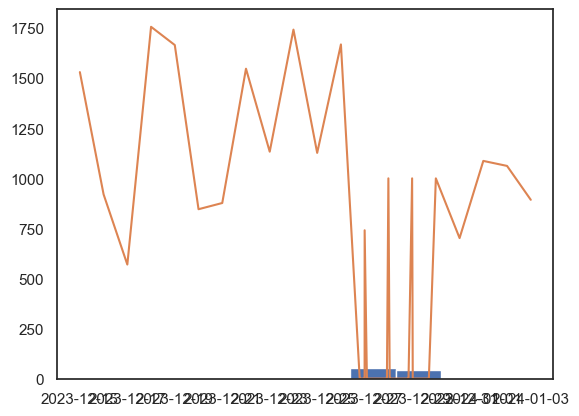

In [192]:

# Plot the histogram
plt.hist(temp_df['timestamp'])

# Plot the line 
plt.plot(temp_df['timestamp'], temp_df['count'])

# Show the plot
plt.show()


In [137]:
temp_df[temp_df['mean']>=temp_df['mean'].max()]

,mean
timestamp,
2023-12-28 17:55:05.229095680,-0.010535


In [141]:
temp_df[temp_df['mean']<=temp_df['mean'].min()]

,mean
timestamp,
2023-12-27 11:36:21.684869120,-0.011357


In [139]:
anomalies['timestamp']

0    2023-12-28 14:56:18.466853888
1    2023-12-27 11:43:33.212182784
2    2023-12-27 17:24:09.281293824
3    2023-12-28 13:15:54.697282304
4    2023-12-27 19:16:53.274398464
                  ...             
85   2023-12-29 02:53:50.198213376
86   2023-12-29 08:21:27.448379392
87   2023-12-26 20:13:20.164763392
88   2023-12-27 14:02:52.076538112
89   2023-12-26 23:33:51.601413376
Name: timestamp, Length: 90, dtype: datetime64[ns]

C:\Users\sadak\AppData\Local\Temp\ipykernel_6068\601592256.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


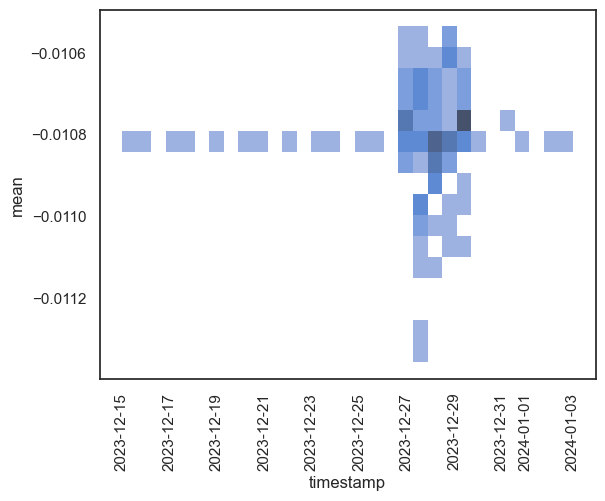

In [129]:
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set_style("white")
g = sns.histplot(data=temp_df, x='timestamp', y='mean')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
# g.set(xlim=(0, 7))
plt.show()

In [101]:
plt.show()

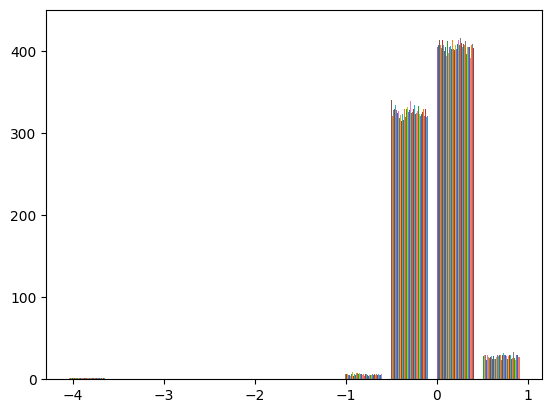

In [7]:

plt.hist(x=X_train[1:])
plt.show()

## Ecludian distance

Our approach is to calculate the ecludian distance bettwen embeddings of prod data and temp_df

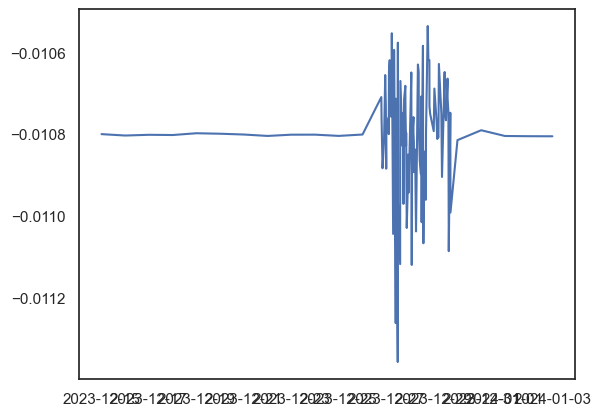

In [144]:
temp_df.reset_index(inplace=True)
plt.plot(temp_df['timestamp'], temp_df['mean'], label = 'close' )
plt.show()

KS test, 1,2 sample

In [2]:
X_prod

NameError: name 'X_prod' is not defined

In [160]:
temp_df